# Example of TSA Inference for Cytokinesis model (Zumdieck)

Details of the model, the inference and background given in the manuscript.

In [2]:
# basics
import numpy as np
import scipy.special as sp

# dynesty
import dynesty
from dynesty import plotting as dyplot

# plotting
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

# seed the random number generator
rstate = np.random.default_rng(5647)

### analytic expressions for forces of candidate models

The hypergeometric functions, needed in the general form of the TSA force, can be numerically unstable for certain parameter ranges. We therefore opted to calculate additional expressions for the discrete cases used in the cytokinesis example.

For inference we assume that the forward dynamics assume an effective SDE written as a Langevin equation:
$dx = -\gamma x^\alpha \ dt + \sqrt{D} \ dW_t$

In [3]:
def force_func(gam, D, alpha, x):
    """ general expression for TSA force. """
    eps = 0.05
    if(n>(-1+eps) ):
        y = - (2*x**(1 + alpha) *gam)/(D*(1 + alpha))           
        denom = x*sp.hyp1f1(1,1 + 1/(1 + alpha) , y)
        force = D / denom - gam*x**alpha
    elif(n< (-1 -eps) ):
        y = - (2*x**(1 + alpha) *gam)/(D*(1 + alpha))
        denom = x*sp.hyperu(1,1 + 1/(1 + alpha) , y)
        force = - D*(alpha+1) /denom - gam*x**alpha
    else:
        force = - alpha*D/x + gam*x**alpha
    return force

def bessel_force(gam, D, x):
    """ TSA force for bessel process (alpha = -1) """
    force = (D+gam)/x
    return force

def OU_force(gam, D, x):
    """ TSA force for Ornstein-Uhlenbeck process (alpha = 1) """
    force = -gam*x + np.sqrt(gam*D)/sp.dawsn(x * np.sqrt(gam/D))
    return force

def drift_force(gam, D, x):
    """ TSA force for advection process (alpha = 0) """
    expon = np.exp(-(2*gam*x)/D )
    nl_fac = (2*gam ) /(1.0- expon) 
    force = -gam + nl_fac
    return force

def neg_two_force(gam, D, x):
    """ TSA force for alpha = -2 """
    y = 2*gam/(D*x)
    force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
    
    # for numerical stability treat values y>100 separately
    if np.any(y>100):
        mask = np.where(y>100)
        force[mask] = D/x[mask] + gam /x[mask]**2
    return force

def force_discrete(gamma, D, alpha, x):
    """ specifiying which force function is used for given alpha """
    if alpha == 1.0:
        force = OU_force(gamma, D, x)
        return force
    elif alpha == 0.0:
        force = drift_force(gamma, D, x)
        return force
    elif alpha == -1.0:
        force = bessel_force(gamma, D, x)
        return force
    elif alpha == -2.0:
        force = neg_two_force(gamma, D, x)
        return force
    else:
        print('alpha value is not within the set of values used in the cytokinesis example.')

### define path log-likelihood and prior transform

In [4]:
def loglikelihood_array_discrete_alpha(p, x, dx, dt):
    """ path likelihood function """
    
    gamma = p[0]
    D = p[1]
    alpha = p[2]
    
    var_p = 2*D*dt
    norm = np.sqrt(np.pi * var_p)    
    singleLogLike_ar = - ((dx - force_discrete(gamma, D, alpha, x)*dt)**2) / var_p - np.log(norm)      
    singleLogLike = np.nansum(singleLogLike_ar)
    
    if np.isnan(singleLogLike) or np.isinf(singleLogLike):
        singleLogLike = -np.inf
    
    return singleLogLike

In [5]:
def prior_transform_discrete_alpha(u):
    """ Transforms unit cube samples u to a flat prior between the specified values in each variable """
    ustar = u*np.array([0.5,0.1,4]) + np.array([0.0, 0.0, -2.5])
    
    if ustar[2] > 0.5:
        ustar[2] = 1.0
    elif ustar[2] > -0.5:
        ustar[2] = 0.0
    elif ustar[2] > -1.5:
        ustar[2] = -1.0
    elif ustar[2] > -2.5:
        ustar[2] = -2.0
    
    return ustar

### load ensemble from cytokinesis simulation data

In [73]:
tsarr = np.load("D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\cytokinExample_oldsavedcode\\x_besselhighres.npy")
#tsarr = np.load("D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generateCytokinEnsemble\\x_besselhighres_test.pickle",allow_pickle=True)
tsarr = np.load("D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generateCytokinEnsemble\\x_besselhighres50000.pickle",allow_pickle=True)

# select a subsample of the data for realism (20000 trajectories)
#tsarr = tsarr[:, :1000]
x1 = np.roll(tsarr,-1,0)
dx = x1[:-1]-tsarr[:-1]
x = tsarr[:-1]


visualizing simulation data together with small noise theory for mean and variance

In [7]:
def mean_tsa_sn_mult(t,gam,d,alpha,beta):
    if alpha <0:
        frac1 = (t*(1 - alpha)*gam)**(1/(1 - alpha))
        nom2 = d*(7*alpha**2 + 2*beta*(1 + beta) - alpha*(3 + 8*beta))*(-t*(-1 + alpha)*gam)**((alpha - beta)/(-1 + alpha))
        denom2 = 2*(2*alpha - beta)*(-1 + 3*alpha - beta)*gam
        frac2 = nom2/denom2
        out = frac1 + frac2
    else:
        out = np.ones(len(t))*np.nan
    return out
    
def var_tsa_sn_mult(t,gam,d,alpha,beta):
    if alpha < 0:
        out = d*(t*(-1 + alpha)*(t*(gam - alpha*gam))**(beta/(1 - alpha)))/(-1 + 3*alpha - beta)
    else:
         out = np.ones(len(t))*np.nan
    return out

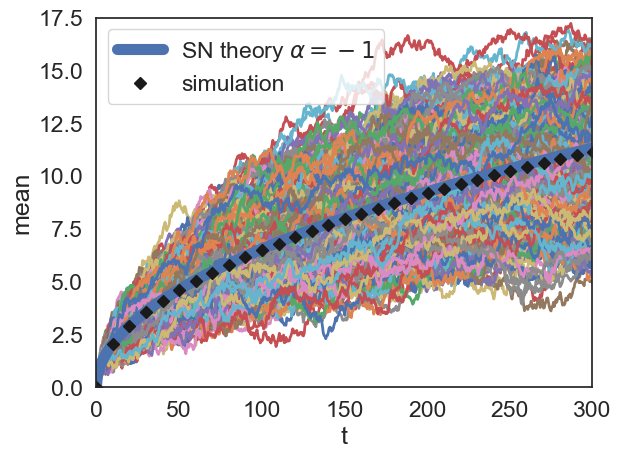

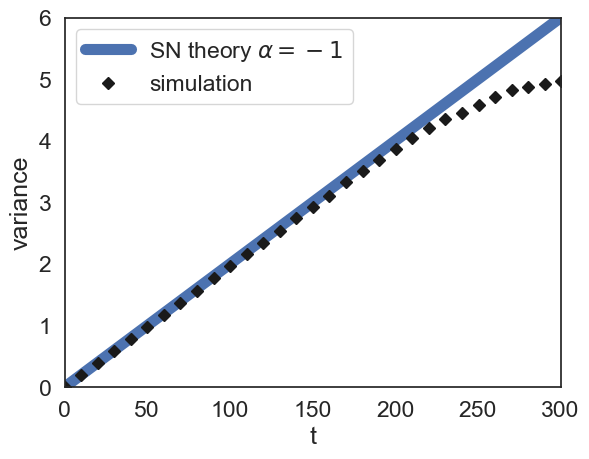

In [74]:
meanarr = np.nanmean(tsarr[::1,:], axis=1)
vararr = np.nanvar(tsarr[::1,:],axis=1)

t = np.linspace(0,0.5*len(meanarr), len(meanarr)) # timestep in simulation was 0.5 in this case
meantheo = mean_tsa_sn_mult(t,0.16,0.04,-1,0)
vartheo = var_tsa_sn_mult(t,0.16,0.04,-1,0)


figmean = plt.figure()
for i in np.arange(tsarr.shape[0]):
    plt.plot(t, tsarr[::1, i])

plt.plot(t,meantheo,linewidth=8,c='b', label=r'SN theory $\alpha=-1$')
plt.plot(t[::20],meanarr[::20],'D', c='k', linewidth=3, label='simulation')
plt.ylabel('mean')
plt.xlabel('t')
plt.ylim(0,17.5)
plt.xlim(0,300)
plt.legend()
plt.show()


figvar = plt.figure()
plt.plot(t,vartheo,linewidth=8, c='b', label=r'SN theory $\alpha=-1$')
plt.plot(t[::20],vararr[::20],'D', c='k', label='simulation')
plt.ylabel('variance')
plt.xlabel('t')
plt.xlim(0,300)
plt.ylim(0,6)
plt.legend()
plt.show()

### running inference with dynesty

dropping first 20 samples (close to the target state) to ensure gaussianity of transition probabilities

In [9]:
timestep = 0.5
data = [x[20:,:], dx[20:,:], timestep]

initiate sampler mostly with default options

In [10]:
ndim=3
Nlivepoints = 200
sampler = dynesty.NestedSampler(loglikelihood_array_discrete_alpha, prior_transform_discrete_alpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

run nested sampling

In [11]:
sampler.run_nested()

357it [01:26,  1.97it/s, bound: 0 | nc: 6 | ncall: 1142 | eff(%): 31.261 | loglstar:   -inf < 287143.289 <    inf | logz: 287135.517 +/-  0.197 | dlogz: 23863.905 >  0.209] C:\Users\nn\AppData\Local\Temp\ipykernel_26500\4158230291.py:36: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
2711it [17:51,  2.53it/s, +200 | bound: 21 | nc: 1 | ncall: 13568 | eff(%): 21.776 | loglstar:   -inf < 310717.686 <    inf | logz: 310705.819 +/-  0.233 | dlogz:  0.001 >  0.209]


### evaluation

true parameters used in ground truth simulation (see simulation code in this repository or see later in this notebook how to calculate $\gamma$. $D$ is always the same here.

$\alpha = -1$     
$\gamma = 0.16$    
$D = 0.04$

In [12]:
res = sampler.results
print('Keys:', res.keys(),'\n')  # accesible keys in the results object, see "dynesty" documentation for details
res.summary()  # print summary

Keys: ['nlive', 'niter', 'ncall', 'eff', 'samples', 'blob', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'] 

Summary
nlive: 200
niter: 2711
ncall: 13368
eff(%): 21.776
logz: 310705.819 +/-  0.320


C:\Users\nn\anaconda3\envs\sf\lib\site-packages\dynesty\plotting.py:749: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])


<Figure size 1000x200 with 0 Axes>

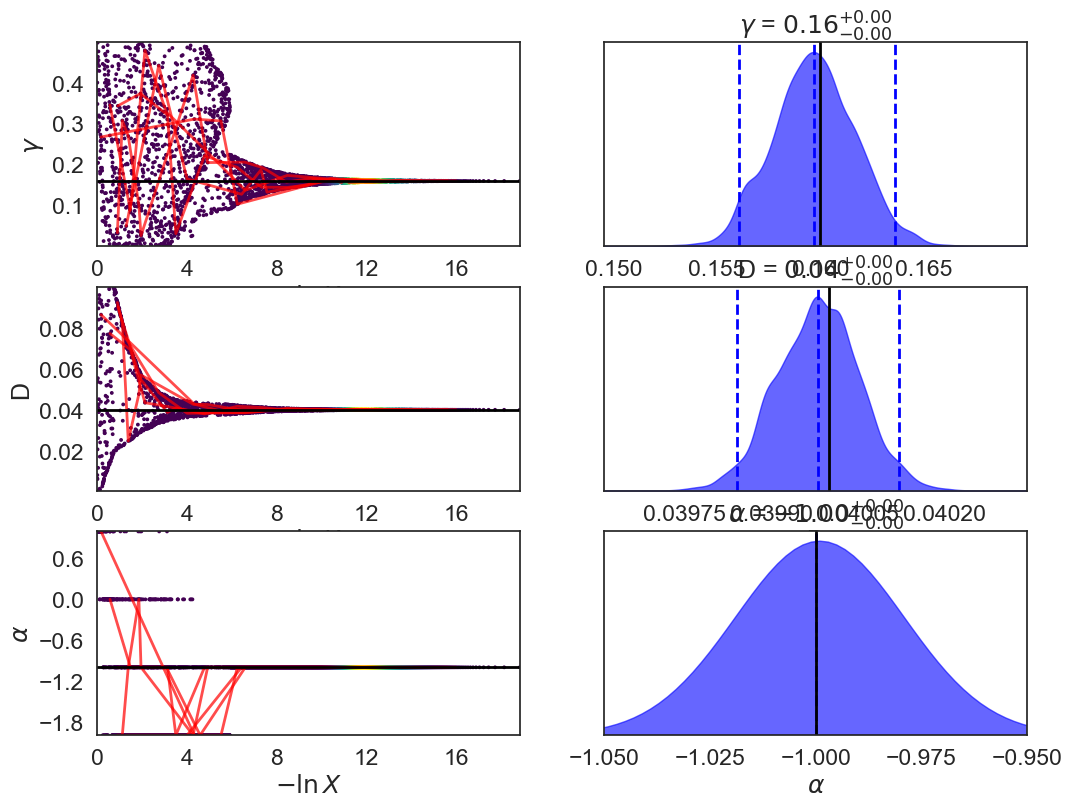

In [19]:
## true parameters known from cytokinesis simulation
ptrue = [0.16,0.04,-1]

## plotting using dyplot from dynesty
plt.figure(figsize=(10,2))
fig, axes = dyplot.traceplot(res, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D', r'$\alpha$'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

### inference for fixed alpha

We now fix $\alpha = 0, \alpha=-2$ in order to find the best possible parameters $\gamma$ and $D$ that explain the given TSA ensemble for the "wrong" effective alphas. Afterwards we summarize the results by plotting mean and variance for all cases together.  

In [199]:
# prior transform
def prior_transform_withoutalpha(u):
    """Prior transform for only gamma and D"""
    return u*np.array([3.0,1.0]) + np.array([0.0, 0.0])

# forces
def bessel_force(gam, D, x):
    force = (D+gam)/x
    return force

def OU_force(gam, D, x):
    force = -gam*x + np.sqrt(gam*D)/sp.dawsn(x * np.sqrt(gam/D))
    return force

def drift_force(gam, D, x):
    expon = np.exp(-(2*gam*x)/D )
    nl_fac = (2*gam ) /(1.0- expon) 
    force = -gam + nl_fac
    return force

def neg_two_force(gam, D, x):
    y = 2*gam/(D*x)
    force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
    if np.any(y>100):
        force[np.where(y>100)] = D/x[np.where(y>100)] + gam /x[np.where(y>100)]**2
    return force

# likelihood for each specific alpha
def loglikelihood_array_advection(p, x, dx, dt):
    """LogL for drift case, alpha=0. 
    Note that one could simply pass the force function as an argument. We do it explicitly here for clarity."""
    gamma = p[0]
    D = p[1]
    
    var_p = 2*( D*dt) 
    norm = np.sqrt(np.pi * var_p )    
    singleLogLike_ar = - 0.5*((dx - drift_force(gamma, D, x)*dt)**2) / var_p - 0.5*np.log(norm)      
    singleLogLike = np.nansum(singleLogLike_ar)
    if np.isnan(singleLogLike) or np.isinf(singleLogLike):
        singleLogLike = -np.inf
    return singleLogLike

def loglikelihood_array_bessel(p, x, dx, dt):
    """LogL for bessel case, alpha=-1. 
    Note that one could simply pass the force function as an argument. We do it explicitly here for clarity."""
    gamma = p[0]
    D = p[1]
    
    var_p = 2*( D*dt) 
    norm = np.sqrt(np.pi * var_p )    
    singleLogLike_ar = - 0.5*((dx - bessel_force(gamma, D, x)*dt)**2) / var_p - 0.5*np.log(norm)      
    singleLogLike = np.nansum(singleLogLike_ar)
    if np.isnan(singleLogLike) or np.isinf(singleLogLike):
        singleLogLike = -np.inf
    return singleLogLike

def loglikelihood_array_neg_two(p, x, dx, dt):
    """LogL for neg two case, alpha=-2. 
    Note that one could simply pass the force function as an argument. We do it explicitly here for clarity."""
    gamma = p[0]
    D = p[1]
    
    var_p = 2*( D*dt) 
    norm = np.sqrt(np.pi * var_p )    
    singleLogLike_ar = - 0.5*((dx - neg_two_force(gamma, D, x)*dt)**2) / var_p - 0.5*np.log(norm)      
    singleLogLike = np.nansum(singleLogLike_ar)
    if np.isnan(singleLogLike) or np.isinf(singleLogLike):
        singleLogLike = -np.inf
    return singleLogLike

def loglikelihood_array_OU(p, x, dx, dt):
    """LogL for neg two case, alpha=1. 
    Note that one could simply pass the force function as an argument. We do it explicitly here for clarity."""
    gamma = p[0]
    D = p[1]
    
    mask = np.logical_or(~np.isnan(x), ~np.isnan(dx))
    
    var_p = 2*( D*dt) 
    norm = np.sqrt(np.pi * var_p )    
    singleLogLike_ar = - 0.5*((dx[mask] - OU_force(gamma, D, x[mask])*dt)**2) / var_p - 0.5*np.log(norm)      
    singleLogLike = np.nansum(singleLogLike_ar)
    if np.isnan(singleLogLike) or np.isinf(singleLogLike):
        singleLogLike = -np.inf
    return singleLogLike

Now do nested sampling as above. First do inference for fixed $\alpha = 0$

In [18]:
ndim=2
Nlivepoints = 200
sampler_advection = dynesty.NestedSampler(loglikelihood_array_advection, prior_transform_withoutalpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

sampler_advection.run_nested()

3298it [16:05,  3.42it/s, +200 | bound: 17 | nc: 1 | ncall: 12703 | eff(%): 27.977 | loglstar:   -inf < 154797.584 <    inf | logz: 154782.789 +/-  0.263 | dlogz:  0.001 >  0.209]


In [20]:
res_advec = sampler_advection.results
res_advec.summary()  # print summary

Summary
nlive: 200
niter: 3298
ncall: 12503
eff(%): 27.977
logz: 154782.789 +/-  0.359


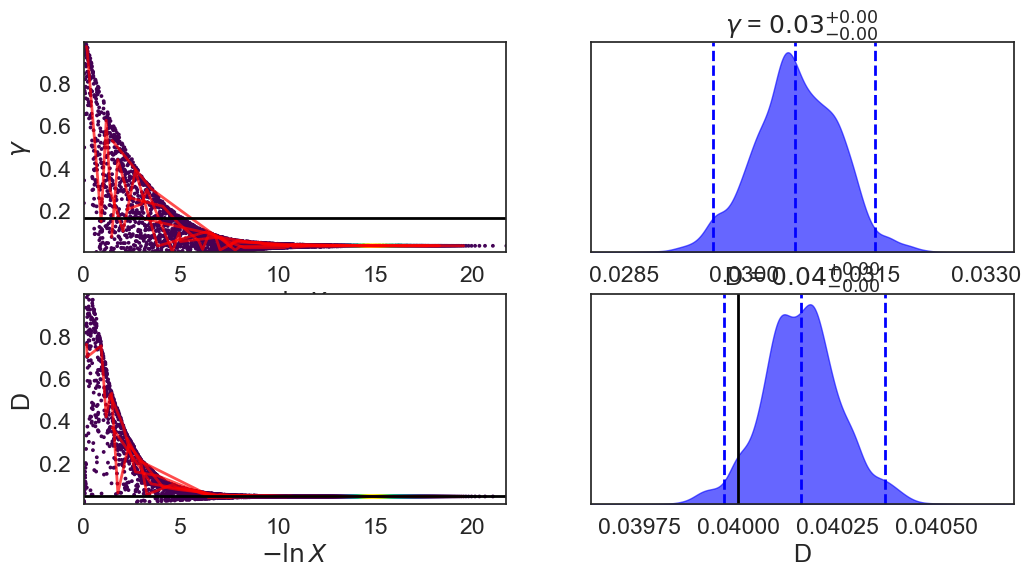

In [21]:
## true parameters known from cytokinesis simulation
ptrue = [0.16,0.04]

#plt.figure(figsize=(10,2))
## plotting using dyplot from dynesty
fig, axes = dyplot.traceplot(res_advec, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

Inference for fixed $\alpha=-2$

In [15]:
ndim=2
Nlivepoints = 200
sampler_negtwo = dynesty.NestedSampler(loglikelihood_array_neg_two, prior_transform_withoutalpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

sampler_negtwo.run_nested()

68it [00:11,  8.14it/s, bound: 0 | nc: 1 | ncall: 285 | eff(%): 23.860 | loglstar:   -inf < -119421.049 <    inf | logz: -119427.380 +/-  0.178 | dlogz: 274377.991 >  0.209]C:\Users\nn\AppData\Local\Temp\ipykernel_26500\1352181406.py:24: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
2720it [38:08,  1.19it/s, +200 | bound: 13 | nc: 1 | ncall: 10788 | eff(%): 27.578 | loglstar:   -inf < 155082.971 <    inf | logz: 155071.054 +/-  0.233 | dlogz:  0.001 >  0.209]


In [16]:
res_negtwo = sampler_negtwo.results
res_negtwo.summary()  # print summary

Summary
nlive: 200
niter: 2720
ncall: 10588
eff(%): 27.578
logz: 155071.054 +/-  0.320


<Figure size 1000x200 with 0 Axes>

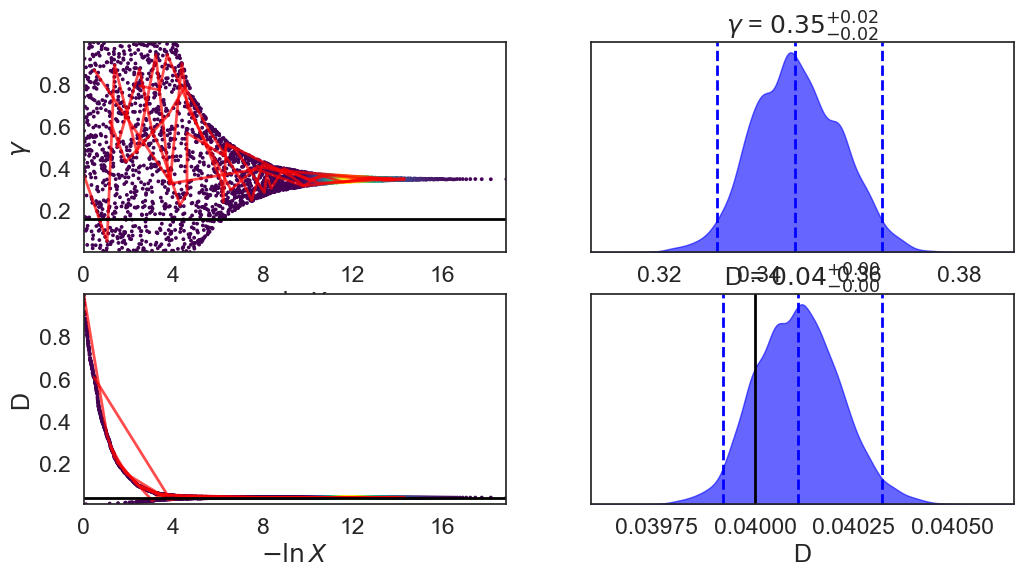

In [17]:
## true parameters known from cytokinesis simulation
ptrue = [0.16,0.04]

plt.figure(figsize=(10,2))
## plotting using dyplot from dynesty
fig, axes = dyplot.traceplot(res_negtwo, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

Now we plot all the results together to compare the inferred means and variances for the effective Bessel ensemble. 

To this end, we took the inferred parameters and performed simulations of the effective Langevin equation $dx = -\gamma x^\alpha dt + \sqrt{D} dW_t$. To be very explicit, we did not do these simulations with the cytokinesis code. The code to obtain the ensemble, generated from the effective Langevin equation with a power law force, is given in this repository. Here we only load the results into the notebook and plot the results. 

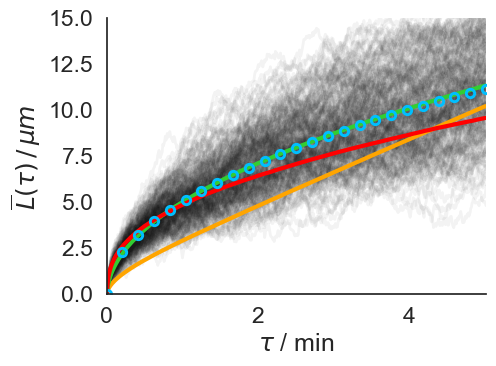

In [108]:
### calculate mean from cytokinesis ensemble (called Zumdieck in plot)
meanarr = np.nanmean(tsarr[::1,:], axis=1)

t = np.linspace(0,timestep*len(meanarr), len(meanarr))
#meantheo = mean_tsa_sn_mult(t,0.16,0.04,-1,0)
#vartheo = var_tsa_sn_mult(t,0.16,0.04,-1,0)


figmean = plt.figure(figsize=(5.3,4))

### plot trajectories
for i in np.arange(250):#np.arange(tsarr.shape[0]):
    plt.plot(t/60, tsarr[::1, i], c='k', alpha=0.05)
    
### parameters for loading the simulation data
datapath = "D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generatePowerlawEnsemble\\"
beta = 0
nrealiz=50000
alpha_ar = [0.0, -1.0, -2.0]
gamma_ar = [0.03, 0.16, 0.35] #inferred parameters
D_ar = [0.04,0.04,0.04] #inferred parameters

colordict = {'0': 'orange', 
            '-1': 'limegreen',
            '-2': 'red'}

### loading and plotting results of effective Langevin equation with power law
for i in np.arange(len(alpha_ar)):
    alpha = alpha_ar[i]
    gamma = gamma_ar[i]
    D = D_ar[i]
    md = np.loadtxt(datapath + "mean_gamma{}_D{}_alpha{}_beta{}_N{}.txt".format(int(gamma*10),int(D*10), int(alpha*10), int(beta*10), nrealiz))
    plt.plot(t[:-1]/60, md, label=r"$\alpha =$ {}".format(int(alpha)), c=colordict[str(int(alpha))], linewidth=3)
    
### plot Zumdieck
plt.plot(t[::25]/60,meanarr[::25],'o',markeredgecolor= 'deepskyblue',markeredgewidth=2.1,markerfacecolor='none', linewidth=3, label='Zumdieck')


sns.despine()

plt.xlabel(r'$\tau$ / min')
plt.ylabel(r'$\overline{L}(\tau) \, / \, \mu m$ ')
plt.ylim(0,15)
plt.xlim(0,timestep*len(meanarr)/60)
#plt.legend()

plt.tight_layout()
plt.savefig('means_cytokin_inference.pdf')
plt.show()


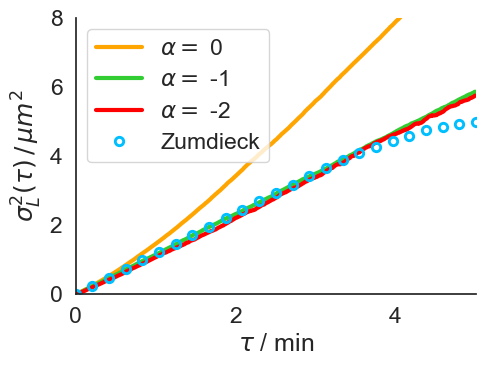

In [107]:
### calculate variance from original cytokinesis ensemble (called Zumdieck below)
vararr = np.nanvar(tsarr[::1,:],axis=1)

### parameters for loading the simulation data
datapath = "D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generatePowerlawEnsemble\\"
beta = 0
nrealiz=50000
alpha_ar = [0.0, -1.0, -2.0]
gamma_ar = [0.03, 0.16, 0.35] #inferred parameters
D_ar = [0.04,0.04,0.04] #inferred parameters

colordict = {'0': 'orange', 
            '-1': 'limegreen',
            '-2': 'red'}

### plotting effective Langevin results
figvar = plt.figure(figsize=(5.2,4))
for i in np.arange(len(alpha_ar)):
    alpha = alpha_ar[i]
    gamma = gamma_ar[i]
    D = D_ar[i]
    mv = np.loadtxt(datapath + "var_gamma{}_D{}_alpha{}_beta{}_N{}.txt".format(int(gamma*10),int(D*10), int(alpha*10), int(beta*10), nrealiz))
    plt.plot(t[:-1]/60, mv, label=r"$\alpha =$ {}".format(int(alpha)), c=colordict[str(int(alpha))], linewidth=3)
    
### plot Zumdieck
plt.plot(t[::25]/60,vararr[::25],'o',markeredgecolor= 'deepskyblue',markeredgewidth=2.1,markerfacecolor='none', linewidth=3, label='Zumdieck')


sns.despine()

plt.xlabel(r'$\tau$ / min')
plt.ylabel(r'$\sigma_L^2(\tau)\, /\, \mu m^2$')
plt.ylim(0,8)
plt.xlim(0,timestep*len(meanarr)/60)
plt.legend()

plt.tight_layout()

plt.savefig('vars_cytokin_inference.pdf')
plt.show()

# Inference for the other effective models

the code below calculates the effective $\gamma$ from the real parameters, such as the reaction constants, from the cytokinesis simulations

In [ ]:
p0 = [400,10,2000,20,1] # drift
p1 = [0.5,0.01,0,0,1] # bessel
p2 = [0.7,0.1,0,0,2] # -2

# specify case
params = p2
process = 'NESS_neg_two'
alph = 2



kp1= params[0]
kd1= params[1]
kp = params[2]
kd = params[3]

Nb = 40
A = 0.12e-3
r0 = 14.5
K = 10
xi = 3.75e-4        

gamma1pre = 2*K*xi*10
gamma1 = 0
gamma2pre = 20*2*np.pi*A*xi*Nb 
gamma2 = 20*2*np.pi*A*xi*Nb  
c_start_sim = kp1/kd1                
x_start_sim = r0 - gamma2pre*c_start_sim**alph/gamma1pre
rc_fac = x_start_sim*c_start_sim                           

D = 0.04


if(process=='NESS_fwd_bessel'):
    gam=gamma2*rc_fac**alph
    c = gam/D
    pre_fac =1
    stepsize_pre_fac=1

if(process=='NESS_drift'):
    gam = gamma2*(kp/kd)**alph - gamma1*r0
    pre_fac =1
    stepsize_pre_fac=1

if(process=='NESS_OU'):
    gam = gamma2*(kp/kd)**alph - gamma1*r0
    pre_fac =1
    stepsize_pre_fac=1

if(process=='NESS_neg_two'):
    gam=gamma2*rc_fac**alph
    c = gam/D 
    pre_fac =0.1
    stepsize_pre_fac = 2#20
    
print('gamma = ', gam)
print('D = ', D)
print('alpha = ', alph)

## Inference $\alpha$=0

Now we take a new ensemble from the cytokinesis simulation that effectively gives $\alpha=0$. Inference is repeated as above and steps are only explained for changes.

In [109]:
tsarr = np.load("D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generateCytokinEnsemble\\x_drifthighres10000.pickle",allow_pickle=True)

x1 = np.roll(tsarr,-1,0)
dx = x1[:-1]-tsarr[:-1]
x = tsarr[:-1]

In [110]:
timestep = 0.5
data = [x[20:,:1000], dx[20:,:1000], timestep]

In [111]:
ndim=3
Nlivepoints = 200
sampler = dynesty.NestedSampler(loglikelihood_array_discrete_alpha, prior_transform_discrete_alpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

C:\Users\nn\AppData\Local\Temp\ipykernel_26500\1352181406.py:24: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2


In [112]:
sampler.run_nested()

6it [00:00, 54.41it/s, bound: 0 | nc: 1 | ncall: 206 | eff(%):  2.913 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.236 | dlogz:    inf >  0.209]C:\Users\nn\AppData\Local\Temp\ipykernel_26500\1352181406.py:24: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
711it [09:09,  2.14s/it, bound: 1 | nc: 20 | ncall: 7158 | eff(%):  9.933 | loglstar:   -inf < 296125.306 <    inf | logz: 296115.769 +/-  0.218 | dlogz: 15933.599 >  0.209]  C:\Users\nn\AppData\Local\Temp\ipykernel_26500\1352181406.py:24: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
3088it [12:40,  4.06it/s, +200 | bound: 28 | nc: 1 | ncall: 15491 | eff(%): 21.503 | loglstar:   -inf < 312074.733 <    inf | logz: 312060.986 +/-  0.252 | dlogz:  0.001 >  0.209]


C:\Users\nn\anaconda3\envs\sf\lib\site-packages\dynesty\plotting.py:749: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])


<Figure size 1000x200 with 0 Axes>

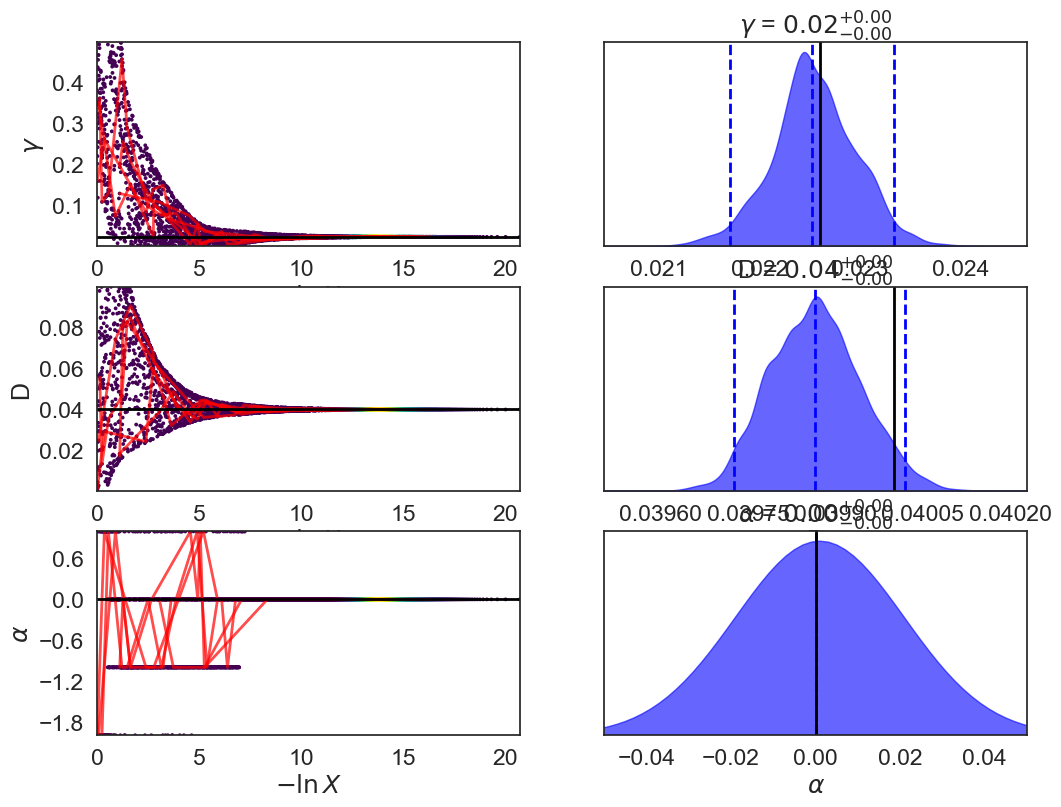

In [153]:
res = sampler.results
## true parameters known from cytokinesis simulation
ptrue = [0.0226,0.04,0]

## plotting using dyplot from dynesty
plt.figure(figsize=(10,2))
fig, axes = dyplot.traceplot(res, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D', r'$\alpha$'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisDrift_new.pdf')
plt.show()

now fixed $\alpha=-1$

In [121]:
ndim=2
Nlivepoints = 200
sampler_drift_bessel = dynesty.NestedSampler(loglikelihood_array_bessel, prior_transform_withoutalpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

sampler_drift_bessel.run_nested()

3120it [02:14, 23.17it/s, +200 | bound: 17 | nc: 1 | ncall: 12621 | eff(%): 26.729 | loglstar:   -inf < 155707.563 <    inf | logz: 155693.651 +/-  0.254 | dlogz:  0.001 >  0.209]


In [122]:
res_drift_bessel = sampler_drift_bessel.results
res_drift_bessel.summary()  # print summary

Summary
nlive: 200
niter: 3120
ncall: 12421
eff(%): 26.729
logz: 155693.651 +/-  0.346


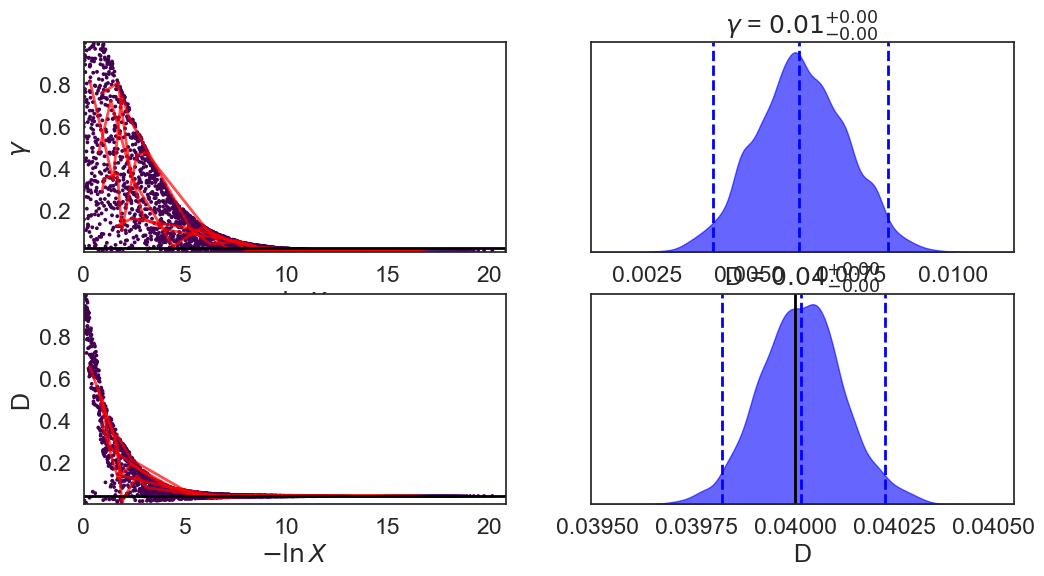

In [123]:
## true parameters known from cytokinesis simulation
ptrue = [0.0226,0.04]

#plt.figure(figsize=(10,2))
## plotting using dyplot from dynesty
fig, axes = dyplot.traceplot(res_drift_bessel, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

now fixed $\alpha=-2$

In [124]:
ndim=2
Nlivepoints = 200
sampler_drift_negtwo = dynesty.NestedSampler(loglikelihood_array_neg_two, prior_transform_withoutalpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

sampler_drift_negtwo.run_nested()

C:\Users\nn\AppData\Local\Temp\ipykernel_26500\4237871190.py:24: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
713it [23:39,  7.15it/s, bound: 1 | nc: 1 | ncall: 6978 | eff(%): 10.218 | loglstar:   -inf < -144772.513 <    inf | logz: -144782.060 +/-  0.218 | dlogz: 289492.838 >  0.209]  C:\Users\nn\AppData\Local\Temp\ipykernel_26500\4237871190.py:24: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
972it [24:23,  3.81it/s, bound: 3 | nc: 1 | ncall: 7564 | eff(%): 12.850 | loglstar:   -inf < -28003.774 <    inf | logz: -28014.614 +/-  0.233 | dlogz: 181566.006 >  0.209]  C:\Users\nn\AppData\Local\Temp\ipykernel_26500\4237871190.py:24: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
1177it [24:56,  7.24it/s, bound: 4 | nc: 1 | ncall: 7960 | eff(%): 14.786 | loglstar:   -inf 

In [125]:
res_drift_negtwo = sampler_drift_negtwo.results
res_drift_negtwo.summary()  # print summary

Summary
nlive: 200
niter: 4917
ncall: 16704
eff(%): 30.633
logz: 155666.605 +/-  0.440


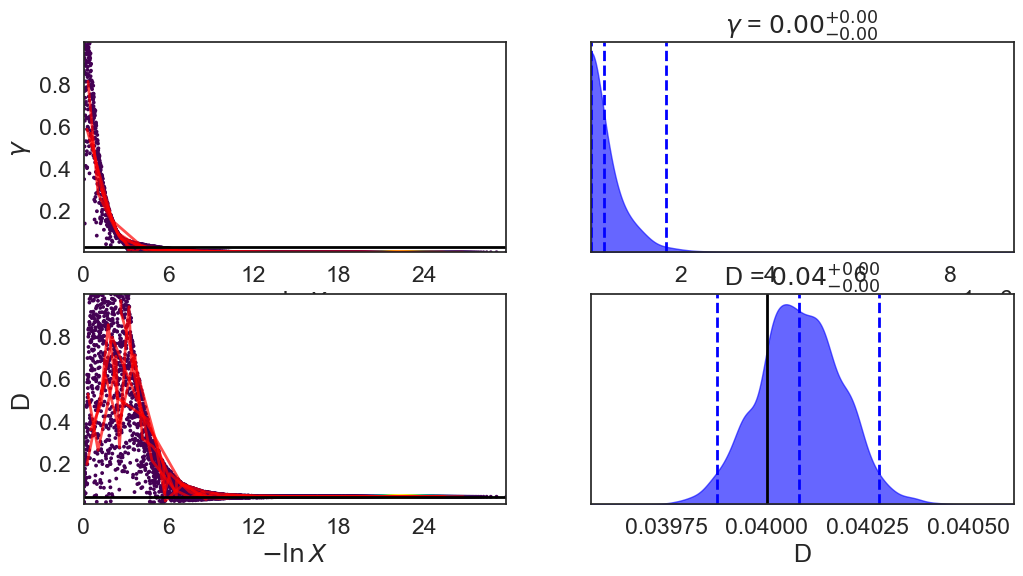

In [126]:
## true parameters known from cytokinesis simulation
ptrue = [0.0226,0.04]

#plt.figure(figsize=(10,2))
## plotting using dyplot from dynesty
fig, axes = dyplot.traceplot(res_drift_negtwo, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

plotting results together

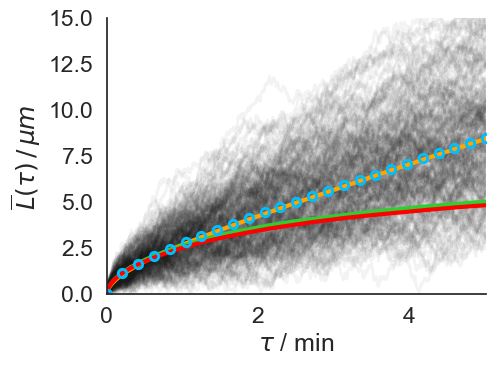

In [128]:
meanarr = np.nanmean(tsarr[::1,:], axis=1)

t = np.linspace(0,timestep*len(meanarr), len(meanarr))
meantheo = mean_tsa_sn_mult(t,0.16,0.04,-1,0)
vartheo = var_tsa_sn_mult(t,0.16,0.04,-1,0)


figmean = plt.figure(figsize=(5.3,4))

### plot trajectories
for i in np.arange(250):#np.arange(tsarr.shape[0]):
    plt.plot(t/60, tsarr[::1, i], c='k', alpha=0.05)
    
### specify parameters to load data and for plotting
datapath = "D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generatePowerlawEnsemble\\"
beta = 0
nrealiz=50000
alpha_ar = [0.0, -1.0, -2.0]
gamma_ar = [0.0226, 0.01, 0.001] #inferred parameters
D_ar = [0.04,0.04,0.04] #inferred parameters

colordict = {'0': 'orange', 
            '-1': 'limegreen',
            '-2': 'red'}

### plotting
for i in np.arange(len(alpha_ar)):
    alpha = alpha_ar[i]
    gamma = gamma_ar[i]
    D = D_ar[i]
    md = np.loadtxt(datapath + "meandrift_gamma{}_D{}_alpha{}_beta{}_N{}.txt".format(int(gamma*10),int(D*10), int(alpha*10), int(beta*10), nrealiz))
    plt.plot(t[:-1]/60, md, label=r"$\alpha =$ {}".format(int(alpha)), c=colordict[str(int(alpha))], linewidth=3)
    
### plot Zumdieck
plt.plot(t[::25]/60,meanarr[::25],'o',markeredgecolor= 'deepskyblue',markeredgewidth=2.1,markerfacecolor='none', linewidth=3, label='Zumdieck')


sns.despine()

plt.xlabel(r'$\tau$ / min')
plt.ylabel(r'$\overline{L}(\tau) \, / \, \mu m$ ')
plt.ylim(0,15)
plt.xlim(0,timestep*len(meanarr)/60)
#plt.legend()

plt.tight_layout()
plt.savefig('means_cytokin_inference_drift.pdf')
plt.show()


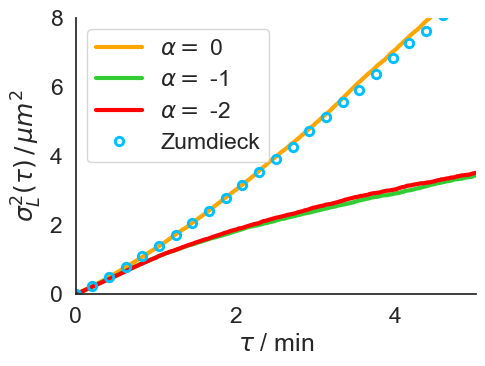

In [129]:
vararr = np.nanvar(tsarr[::1,:],axis=1)

### specify parameters to load data and for plotting
datapath = "D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generatePowerlawEnsemble\\"
beta = 0
nrealiz=50000
alpha_ar = [0.0, -1.0, -2.0]
gamma_ar = [0.0226, 0.01, 0.001] #inferred parameters
D_ar = [0.04,0.04,0.04] #inferred parameters

colordict = {'0': 'orange', 
            '-1': 'limegreen',
            '-2': 'red'}

### plotting
figvar = plt.figure(figsize=(5.2,4))
for i in np.arange(len(alpha_ar)):
    alpha = alpha_ar[i]
    gamma = gamma_ar[i]
    D = D_ar[i]
    mv = np.loadtxt(datapath + "vardrift_gamma{}_D{}_alpha{}_beta{}_N{}.txt".format(int(gamma*10),int(D*10), int(alpha*10), int(beta*10), nrealiz))
    plt.plot(t[:-1]/60, mv, label=r"$\alpha =$ {}".format(int(alpha)), c=colordict[str(int(alpha))], linewidth=3)
    
### plot Zumdieck
plt.plot(t[::25]/60,vararr[::25],'o',markeredgecolor= 'deepskyblue',markeredgewidth=2.1,markerfacecolor='none', linewidth=3, label='Zumdieck')


sns.despine()

plt.xlabel(r'$\tau$ / min')
plt.ylabel(r'$\sigma_L^2(\tau)\, /\, \mu m^2$')
plt.ylim(0,8)
plt.xlim(0,timestep*len(meanarr)/60)
plt.legend()

plt.tight_layout()

plt.savefig('vars_cytokin_inference_drift.pdf')
plt.show()

## Inference $\alpha$=-2

Now we take a new ensemble from the cytokinesis simulation that effectively gives $\alpha=-2$. Inference is repeated as above and steps are only explained for changes.

In [150]:
def prior_transform_discrete_alpha(u):
    """The true gamma value is greater than 1 in this case. Thus we adjust the prior."""
    ustar = u*np.array([3,0.1,4]) + np.array([0.0, 0.0, -2.5])
    
    if ustar[2] > 0.5:
        ustar[2] = 1.0
    elif ustar[2] > -0.5:
        ustar[2] = 0.0
    elif ustar[2] > -1.5:
        ustar[2] = -1.0
    elif ustar[2] > -2.5:
        ustar[2] = -2.0
    
    return ustar

In [144]:
tsarr = np.load("D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generateCytokinEnsemble\\x_neg_twohighres10000.pickle",allow_pickle=True)

# only select a subsample of the data (10000 trajectories)
#tsarr = tsarr[:, :20000]
x1 = np.roll(tsarr,-1,0)
dx = x1[:-1]-tsarr[:-1]
x = tsarr[:-1]

In [159]:
timestep = 0.5
data = [x[20:,:1000], dx[20:,:1000], timestep]

In [156]:
ndim=3
Nlivepoints = 200
sampler_negtwo = dynesty.NestedSampler(loglikelihood_array_discrete_alpha, prior_transform_discrete_alpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

In [157]:
sampler_negtwo.run_nested()

183it [00:39,  2.62it/s, bound: 0 | nc: 1 | ncall: 502 | eff(%): 36.454 | loglstar:   -inf < 227872.177 <    inf | logz: 227865.273 +/-  0.186 | dlogz: 412130.907 >  0.209]  C:\Users\nn\AppData\Local\Temp\ipykernel_26500\4237871190.py:24: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
2834it [46:59,  1.01it/s, +200 | bound: 20 | nc: 1 | ncall: 13010 | eff(%): 23.685 | loglstar:   -inf < 636361.320 <    inf | logz: 636348.839 +/-  0.239 | dlogz:  0.001 >  0.209]


C:\Users\nn\anaconda3\envs\sf\lib\site-packages\dynesty\plotting.py:749: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])


<Figure size 1000x200 with 0 Axes>

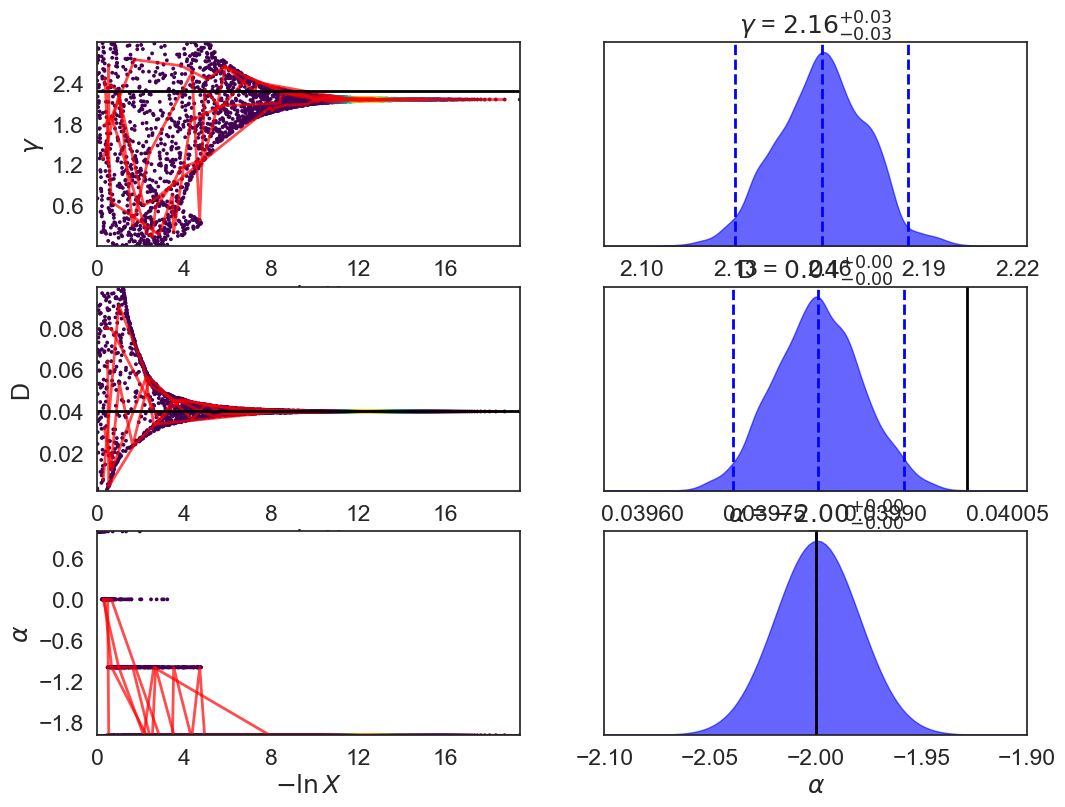

In [158]:
res_negtwo = sampler_negtwo.results
## true parameters known from cytokinesis simulation
ptrue = [2.283,0.04,-2]

## plotting using dyplot from dynesty
plt.figure(figsize=(10,2))
fig, axes = dyplot.traceplot(res_negtwo, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D', r'$\alpha$'],
                             connect_highlight=range(5))

#plt.tight_layout()
plt.savefig('InferenceResultsCytokinesisNegTwo_new.pdf')
plt.show()

inference for fixed $\alpha=-1$

In [164]:
ndim=2
Nlivepoints = 200
sampler_negtwo_bessel = dynesty.NestedSampler(loglikelihood_array_bessel, prior_transform_withoutalpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

sampler_negtwo_bessel.run_nested()

3128it [02:19, 22.38it/s, +200 | bound: 15 | nc: 1 | ncall: 12199 | eff(%): 27.736 | loglstar:   -inf < 155909.386 <    inf | logz: 155895.440 +/-  0.254 | dlogz:  0.001 >  0.209]


In [166]:
res_negtwo_bessel = sampler_negtwo_bessel.results
res_negtwo_bessel.summary()  # print summary

Summary
nlive: 200
niter: 3128
ncall: 11999
eff(%): 27.736
logz: 155895.440 +/-  0.348


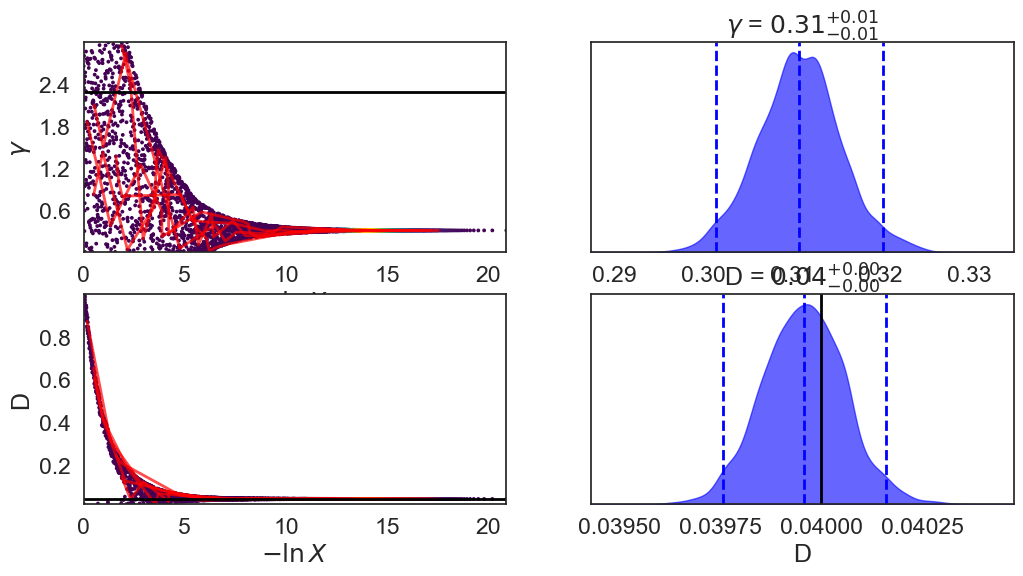

In [167]:
## true parameters known from cytokinesis simulation
ptrue = [2.283,0.04]

## plotting using dyplot from dynesty
#plt.figure(figsize=(10,2))
fig, axes = dyplot.traceplot(res_negtwo_bessel, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

inference for fixed $\alpha=0$

In [168]:
ndim=2
Nlivepoints = 200
sampler_negtwo_drift = dynesty.NestedSampler(loglikelihood_array_advection, prior_transform_withoutalpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

sampler_negtwo_drift.run_nested()

3584it [04:15, 14.05it/s, +200 | bound: 19 | nc: 1 | ncall: 12729 | eff(%): 30.202 | loglstar:   -inf < 155056.268 <    inf | logz: 155040.047 +/-  0.276 | dlogz:  0.001 >  0.209]


In [170]:
res_negtwo_drift = sampler_negtwo_drift.results
res_negtwo_drift.summary()  # print summary

Summary
nlive: 200
niter: 3584
ncall: 12529
eff(%): 30.202
logz: 155040.047 +/-  0.376


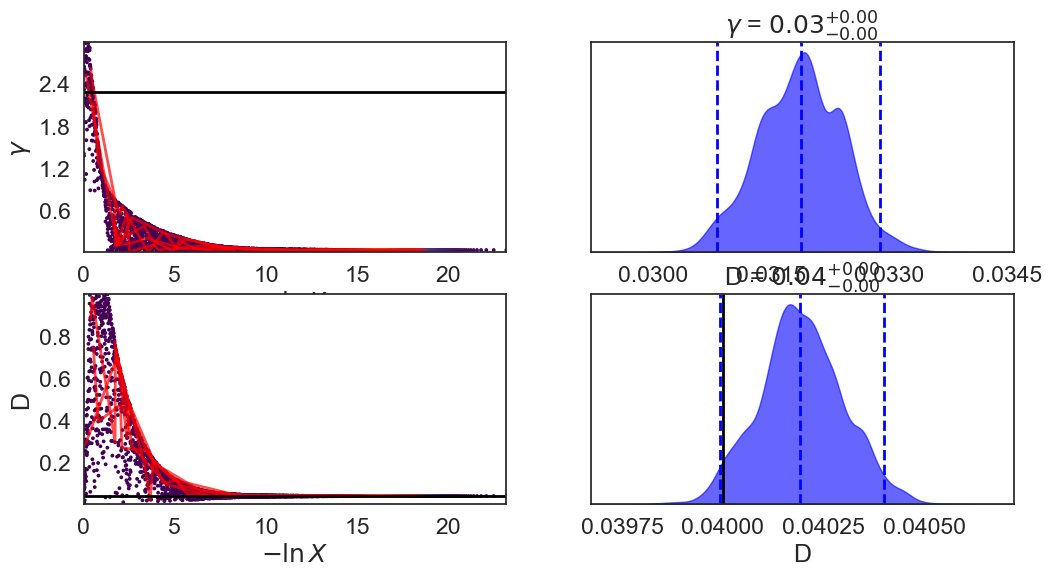

In [171]:
## true parameters known from cytokinesis simulation
ptrue = [2.283,0.04]

## plotting using dyplot from dynesty
#plt.figure(figsize=(10,2))
fig, axes = dyplot.traceplot(res_negtwo_drift, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

plot inference results together

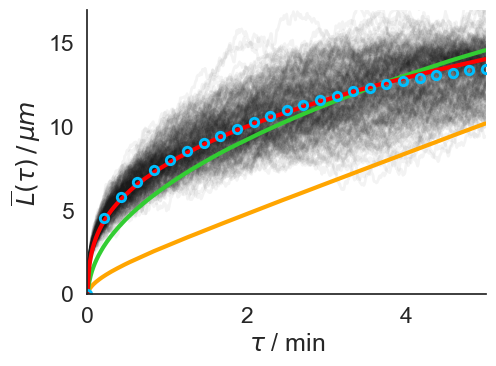

In [176]:
meanarr = np.nanmean(tsarr[::1,:], axis=1)

t = np.linspace(0,timestep*len(meanarr), len(meanarr))
meantheo = mean_tsa_sn_mult(t,0.16,0.04,-1,0)
vartheo = var_tsa_sn_mult(t,0.16,0.04,-1,0)


figmean = plt.figure(figsize=(5.3,4))

### plot trajectories
for i in np.arange(250):#np.arange(tsarr.shape[0]):
    plt.plot(t/60, tsarr[::1, i], c='k', alpha=0.05)
    
### specify parameters to load data and for plotting
datapath = "D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generatePowerlawEnsemble\\"
beta = 0
nrealiz=50000
alpha_ar = [0.0, -1.0, -2.0]
gamma_ar = [0.03, 0.31, 2.16] #inferred parameters
D_ar = [0.04,0.04,0.04] #inferred parameters

colordict = {'0': 'orange', 
            '-1': 'limegreen',
            '-2': 'red'}

### plotting
for i in np.arange(len(alpha_ar)):
    alpha = alpha_ar[i]
    gamma = gamma_ar[i]
    D = D_ar[i]
    md = np.loadtxt(datapath + "meannegtwo_gamma{}_D{}_alpha{}_beta{}_N{}.txt".format(int(gamma*10),int(D*10), int(alpha*10), int(beta*10), nrealiz))
    plt.plot(t[:-1]/60, md, label=r"$\alpha =$ {}".format(int(alpha)), c=colordict[str(int(alpha))], linewidth=3)
    
### plot Zumdieck
plt.plot(t[::25]/60,meanarr[::25],'o',markeredgecolor= 'deepskyblue',markeredgewidth=2.1,markerfacecolor='none', linewidth=3, label='Zumdieck')



sns.despine()

plt.xlabel(r'$\tau$ / min')
plt.ylabel(r'$\overline{L}(\tau) \, / \, \mu m$ ')
plt.ylim(0,17)
plt.xlim(0,timestep*len(meanarr)/60)
#plt.legend()

plt.tight_layout()
plt.savefig('means_cytokin_inference_negtwo.pdf')
plt.show()


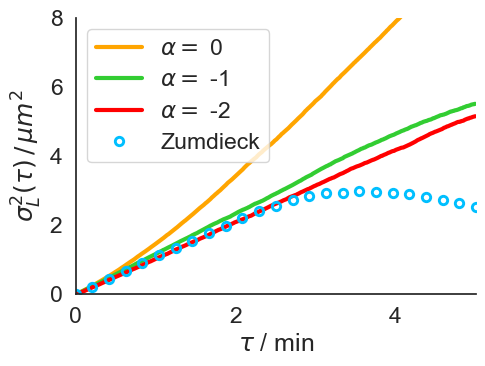

In [175]:
vararr = np.nanvar(tsarr[::1,:],axis=1)


### specify parameters to load data and for plotting
datapath = "D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generatePowerlawEnsemble\\"
beta = 0
nrealiz=50000
alpha_ar = [0.0, -1.0, -2.0]
gamma_ar = [0.03, 0.31, 2.16] #inferred parameters
D_ar = [0.04,0.04,0.04] #inferred parameters

colordict = {'0': 'orange', 
            '-1': 'limegreen',
            '-2': 'red'}

### plotting
figvar = plt.figure(figsize=(5.2,4))
for i in np.arange(len(alpha_ar)):
    alpha = alpha_ar[i]
    gamma = gamma_ar[i]
    D = D_ar[i]
    mv = np.loadtxt(datapath + "varnegtwo_gamma{}_D{}_alpha{}_beta{}_N{}.txt".format(int(gamma*10),int(D*10), int(alpha*10), int(beta*10), nrealiz))
    plt.plot(t[:-1]/60, mv, label=r"$\alpha =$ {}".format(int(alpha)), c=colordict[str(int(alpha))], linewidth=3)
    
### plot Zumdieck
plt.plot(t[::25]/60,vararr[::25],'o',markeredgecolor= 'deepskyblue',markeredgewidth=2.1,markerfacecolor='none', linewidth=3, label='Zumdieck')


sns.despine()

plt.xlabel(r'$\tau$ / min')
plt.ylabel(r'$\sigma_L^2(\tau)\, /\, \mu m^2$')
plt.ylim(0,8)
plt.xlim(0,timestep*len(meanarr)/60)
plt.legend()

plt.tight_layout()

plt.savefig('vars_cytokin_inference_negtwo.pdf')
plt.show()

# Inference for weakly terminal dynamics

In [254]:
loadts2 = np.loadtxt("D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generatePowerlawEnsemble\\num_trj.txt")

loadts2.shape

(2000, 6001)

C:\Users\nn\AppData\Local\Temp\ipykernel_26500\3305582985.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(loadts2,axis=0))


(0.0, 1000.0)

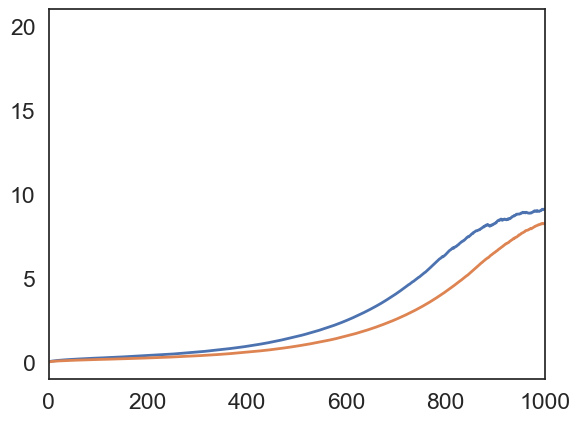

In [260]:
plt.plot(np.nanmean(loadts,axis=1))
plt.plot(np.nanmean(loadts2,axis=0))
plt.xlim(0,1000)

In [233]:
loadts = np.loadtxt("D:\\Forschung\\PapersAndWriting\\SDEmitNico\\PathInferenceCode\\generatePowerlawEnsemble\\num_trj.txt")
loadts = np.transpose(loadts)

loadts = loadts[:1000, :1000] # subsample ensemble further if needed
tsarr = loadts[:,:]
x1 = np.roll(tsarr,-1,0)
dx = x1[:-1]-tsarr[:-1]
x = tsarr[:-1]


In [249]:
timestep = 0.005
data = [x[2:700,:], dx[2:700,:], timestep]

In [250]:
ndim=3
Nlivepoints = 200
sampler_OU_all = dynesty.NestedSampler(loglikelihood_array_discrete_alpha, prior_transform_discrete_alpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

sampler_OU_all.run_nested()

C:\Users\nn\AppData\Local\Temp\ipykernel_26500\127829511.py:23: RuntimeWarning: invalid value encountered in divide
  force = D/x+ 2*gam*sp.expn(1,y)/(x**2 * sp.expn(2,y) ) - gam/x**2
3412it [11:10,  5.09it/s, +200 | bound: 25 | nc: 1 | ncall: 14398 | eff(%): 25.440 | loglstar:   -inf < 1459983.354 <    inf | logz: 1459967.989 +/-  1.322 | dlogz:  0.001 >  0.209]


In [251]:
res_OU_all = sampler_OU_all.results
res_OU_all.summary()  # print summary

Summary
nlive: 200
niter: 3412
ncall: 14198
eff(%): 25.440
logz: 1459967.989 +/-  0.366


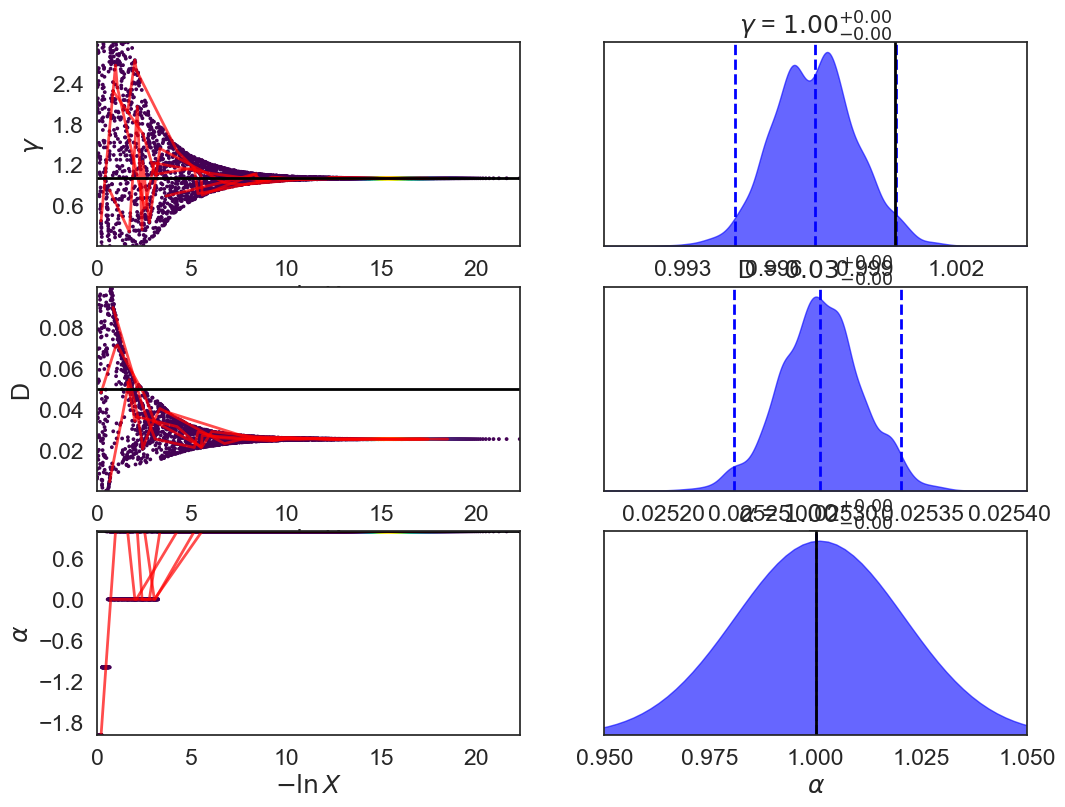

In [253]:
## 2:700
## true parameters known from cytokinesis simulation
ptrue = [1,0.05,1]

## plotting using dyplot from dynesty
#plt.figure(figsize=(10,2))
fig, axes = dyplot.traceplot(res_OU_all, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D', r'$\alpha$'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

C:\Users\nn\anaconda3\envs\sf\lib\site-packages\dynesty\plotting.py:749: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])


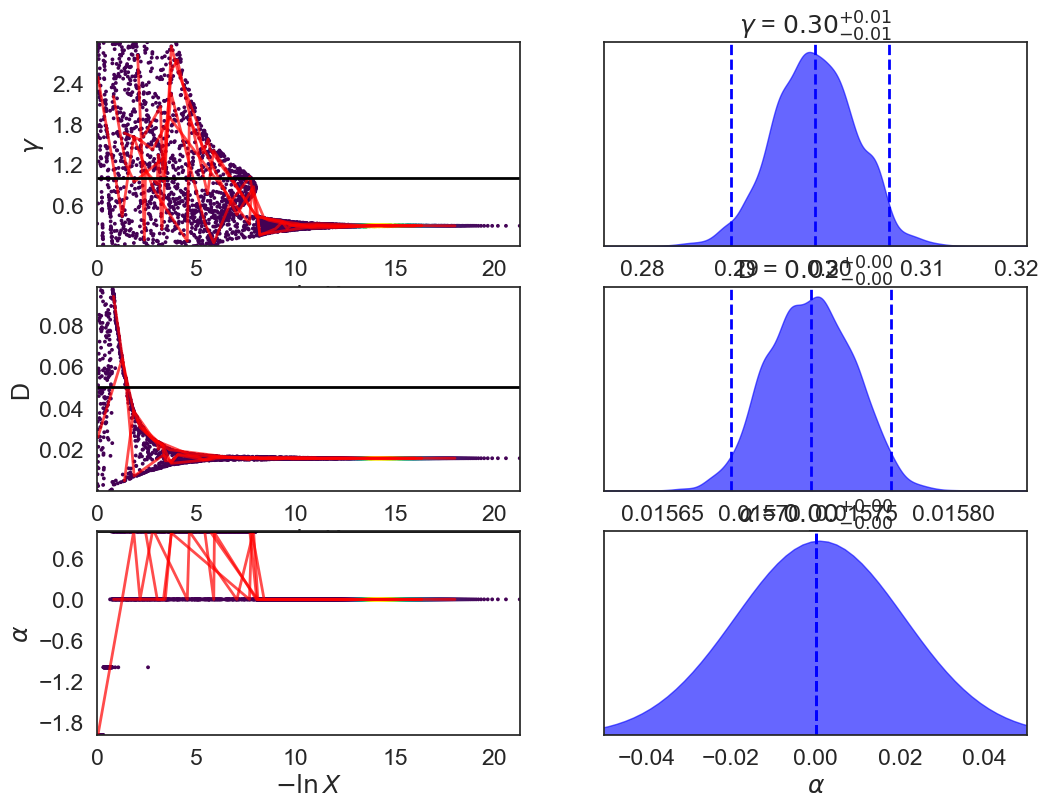

In [248]:
## 2:200
## true parameters known from cytokinesis simulation
ptrue = [1,0.05,1]

## plotting using dyplot from dynesty
#plt.figure(figsize=(10,2))
fig, axes = dyplot.traceplot(res_OU_all, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D', r'$\alpha$'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

C:\Users\nn\anaconda3\envs\sf\lib\site-packages\dynesty\plotting.py:749: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])


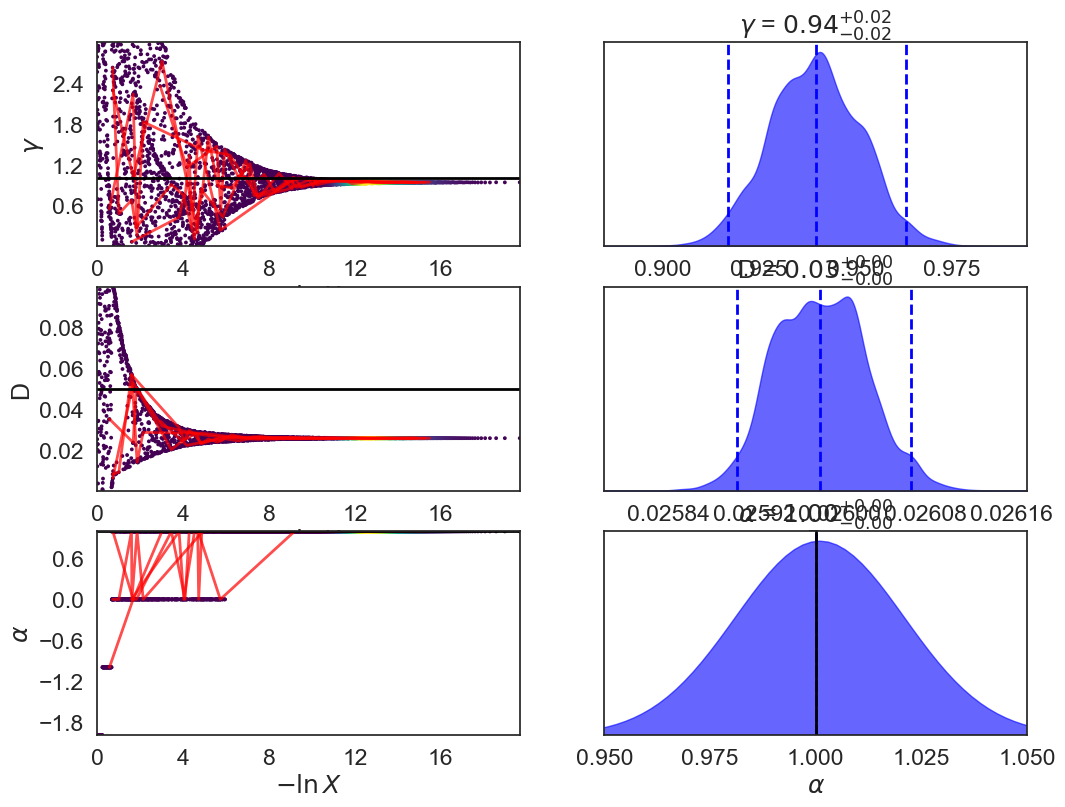

In [241]:
20:400
## true parameters known from cytokinesis simulation
ptrue = [1,0.05,1]

## plotting using dyplot from dynesty
#plt.figure(figsize=(10,2))
fig, axes = dyplot.traceplot(res_OU_all, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D', r'$\alpha$'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

In [235]:
ndim=2
Nlivepoints = 200
sampler_OU = dynesty.NestedSampler(loglikelihood_array_OU, prior_transform_withoutalpha, 
                                ndim, nlive=Nlivepoints,
                                rstate=rstate, 
                                logl_args=data)

sampler_OU.run_nested()

5808it [03:44, 25.88it/s, +200 | bound: 34 | nc: 1 | ncall: 17345 | eff(%): 35.042 | loglstar:   -inf < 1123383.173 <    inf | logz: 1123355.858 +/-  0.362 | dlogz:  0.001 >  0.209]


In [236]:
res_OU = sampler_OU.results
res_OU.summary()  # print summary

Summary
nlive: 200
niter: 5808
ncall: 17145
eff(%): 35.042
logz: 1123355.858 +/-  0.491


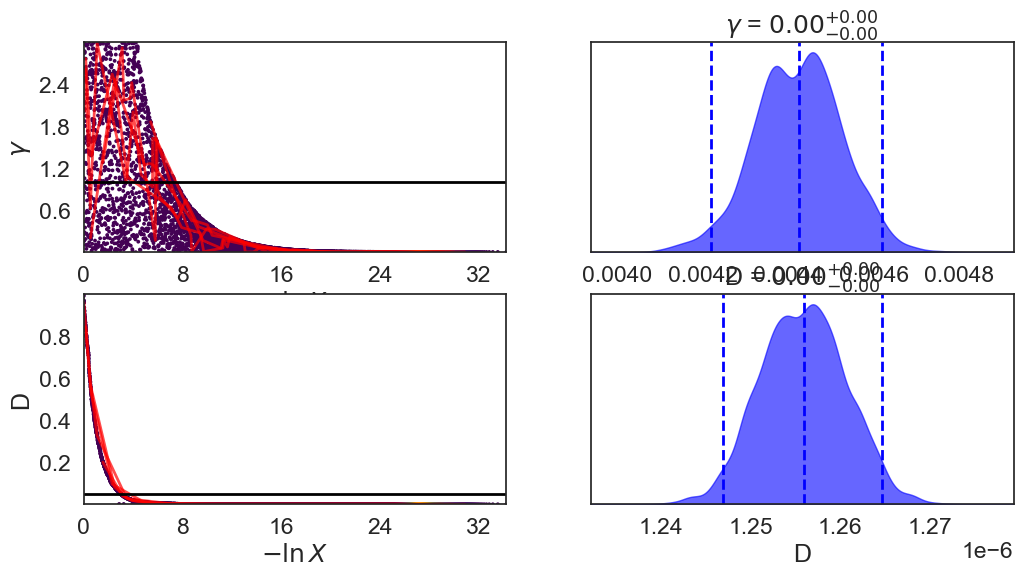

In [237]:
## true parameters known from cytokinesis simulation
ptrue = [1,0.05]

## plotting using dyplot from dynesty
#plt.figure(figsize=(10,2))
fig, axes = dyplot.traceplot(res_OU, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D'],
                             connect_highlight=range(5))

#plt.tight_layout()
#plt.savefig('InferenceResultsCytokinesisBessel_new.pdf')
plt.show()

In [225]:
def loglikelihood_array_OU(p, x, dx, dt):
    """LogL for neg two case, alpha=1. 
    Note that one could simply pass the force function as an argument. We do it explicitly here for clarity."""
    gamma = p[0]
    D = p[1]
    
    var_p = 2*( D*dt) 
    norm = np.sqrt(np.pi * var_p )    
    
    patharg = dx - OU_force(gamma, D, x)
    maskpath = np.logical_or(~np.isnan(patharg), ~np.isinf(patharg))
    
    singleLogLike_ar = - 0.5*((patharg[maskpath])*dt)**2 / var_p - 0.5*np.log(norm)      
    singleLogLike = np.nansum(singleLogLike_ar)
    
    if np.isnan(singleLogLike) or np.isinf(singleLogLike):
        singleLogLike = -np.inf
    return singleLogLike

In [ ]:
def OU_force(gam, D, x):
    force = -gam*x + np.sqrt(gam*D)/sp.dawsn(x * np.sqrt(gam/D))
    return force

In [222]:
loglikelihood_array_OU([0.01,0.5], *data)

-2537806.0875773556

In [219]:
OU_force(1, 0.05, x[40:,1:])

array([[2.12488175, 1.44892415, 2.31888416, ..., 2.5100827 , 2.52517678,
        2.53488866],
       [5.37729903, 3.97925197, 1.9543531 , ..., 6.70546739, 6.76626339,
        6.81293101],
       [2.32073071, 1.58470969, 1.59844647, ..., 8.92862003, 8.94784706,
        9.00080794],
       ...,
       [1.1129237 , 1.79445687, 2.19346424, ...,        nan,        nan,
               nan],
       [1.93443752, 1.1963685 , 1.08463359, ...,        nan,        nan,
               nan],
       [2.0172644 , 0.89503575, 0.70024755, ...,        nan,        nan,
               nan]])